## Background

In this blog post I'll modify the neural net training loop example in Jeremy Howard's Lesson 5 notebook [Linear model and neural net from scratch](https://www.kaggle.com/code/jhoward/linear-model-and-neural-net-from-scratch) to plot training loss, validation loss, and accuracy across a number of training runs. I'll run 100 trainings for the neural net, record the losses and accuracy, and then plot them to see how they vary by epoch and by training loop.

I am also inspired by (and learned from) [this forum post by a fastai community member](https://forums.fast.ai/t/lesson-5-official-topic/96491/79?u=vbakshi) (sign-in required) where they plotted losses, gradients, parameters and accuracy for various training runs that included or excluded `params.grad_zero()` and L2 regularization. They found that for a simple linear model, zeroing the gradients leads to more stable training, smaller coefficients and higher accuracy than letting gradients accumulate each epoch.

## Plan of Attack

I want to record values at the end of each epoch, separated for each training run. I'll create a `recorder` `DataFrame` where I store this data. Here's pseudocode for how the recording will take place, referencing functions defined in Jeremy's notebook and logic used by in the fastai forum post to collect losses and accuracy:

```python
# code to clean data
...

# code to create training and validation xs and ys
...


# new function to run multiple trainings
def training_run(runs=100):
  # initialize recorder object
  recorder = pd.DataFrame(columns=["run", "epoch", "trn_loss", "val_loss", "acc"])
  for run in range(runs):
    # get lists of losses and accuracy
    tl, vl, a = train_model(...)
    # create list of run and epoch values
    r = [run] * len(tl)
    e = [i for i in range(len(tl))]
    # append new data to recorder DataFrame
    row = pd.DataFrame(data={"run": r, "epoch": e, "trn_loss": tl, "val_loss": vl, "acc": a})
    recorder = pd.concat(recorder, row)
  return recorder
    

# modify existing function
def train_model(...):
  tl, vl, a = [], [], []
  for i in range(epochs):
    trn_loss, val_loss, acc = one_epoch(...)
    tl.append(trn_loss)
    vl.append(val_loss)
    a.append(acc)
  return tl, vl, a

# modify existing function
def one_epoch(...):
  trn_loss = calc_loss(...)
  val_loss = calc_loss(...)
  trn_loss.backward()
  with torch.no_grad(): update_coeffs(...)
  acc = calc_acc(...)
  return trn_loss, val_loss, acc

# use existing function to calculate predictions
def calc_preds(...): ...

# use existing function to calculate loss
def calc_loss(...): ...

# use existing function to step the weights
def update_coeffs(...): ...

# use existing function to calculate accuracy
def calc_acc(...): ...

# use existing function to initiate weights
def init_coeffs(...): ...

```

With the pseudocode sketched out, I'll start building out each function next.

## Building the Functions

In [99]:
import torch, numpy as np, pandas as pd, torch.nn.functional as F
from fastai.data.transforms import RandomSplitter
np.set_printoptions(linewidth=140)
torch.set_printoptions(linewidth=140, sci_mode=False, edgeitems=7)
pd.set_option('display.width', 140)

### Initialize Coefficients

In [100]:
def init_coeffs(n_coeff):
    hiddens = [10, 10]  # <-- set this to the size of each hidden layer you want
    sizes = [n_coeff] + hiddens + [1]
    n = len(sizes)
    layers = [(torch.rand(sizes[i], sizes[i+1])-0.3)/sizes[i+1]*4 for i in range(n-1)]
    consts = [(torch.rand(1)[0]-0.5)*0.1 for i in range(n-1)]
    for l in layers+consts: l.requires_grad_()
    return layers,consts

### Calculate Predictions

In [101]:
def calc_preds(coeffs, indeps):
    layers,consts = coeffs
    n = len(layers)
    res = indeps
    for i,l in enumerate(layers):
        res = res@l + consts[i]
        if i!=n-1: res = F.relu(res)
    return torch.sigmoid(res)

### Calculate Loss

In [102]:
def calc_loss(coeffs, indeps, deps): return torch.abs(calc_preds(coeffs, indeps)-deps).mean()

### Update the Coefficients

In [103]:
def update_coeffs(coeffs, lr):
    layers,consts = coeffs
    for layer in layers+consts:
        layer.sub_(layer.grad * lr)
        layer.grad.zero_()

### Calculate Accuracy

In [105]:
def calc_acc(coeffs): return (val_dep.bool()==(calc_preds(coeffs, val_indep)>0.5)).float().mean()

### Train One Epoch

In [167]:
def one_epoch(coeffs, lr):
  trn_loss = calc_loss(coeffs, trn_indep, trn_dep)
  trn_loss.backward()
  with torch.no_grad():
    val_loss = calc_loss(coeffs, val_indep, val_dep)
    update_coeffs(coeffs, lr)
    acc = calc_acc(coeffs)
  return trn_loss, val_loss, acc

### Train a Model

In [193]:
def train_model(epochs, lr, n_coeff, is_seed=True):
  if is_seed: torch.manual_seed(442)
  tl, vl, a = [], [], []
  coeffs = init_coeffs(n_coeff)
  for i in range(epochs):
    trn_loss, val_loss, acc = one_epoch(coeffs, lr)
    tl.append(trn_loss.item())
    vl.append(val_loss.item())
    a.append(acc.item())
  return tl, vl, a

### Train Multiple Models

In [197]:
def train_multiple_models(runs=100, epochs=30, lr=4, n_coeff=12, is_seed=False):
  # initialize recorder object
  recorder = pd.DataFrame(columns=["run", "epoch", "trn_loss", "val_loss", "acc"])
  for run in range(runs):
    # get lists of losses and accuracy
    tl, vl, a = train_model(epochs, lr, n_coeff, is_seed)
    # create list of run and epoch values
    r = [run] * epochs
    e = [i for i in range(epochs)]
    # append new data to recorder DataFrame
    row = pd.DataFrame(data={"run": r, "epoch": e, "trn_loss": tl, "val_loss": vl, "acc": a})
    recorder = pd.concat([recorder, row])
  return recorder

## Plotting Training Results

In this section, I'll import the data, clean it, create training/validation splits, test out my above functions for a single model training loop, run my experiment for 100 training runs, and plot the results.

### Load the Data

In [112]:
from pathlib import Path

cred_path = Path('~/.kaggle/kaggle.json').expanduser()
if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.write_text(creds)
    cred_path.chmod(0o600)

In [113]:
import os

iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
if iskaggle: path = Path("../input/titanic")
else:
  path = Path('titanic')
  if not path.exists():
    import zipfile, kaggle
    kaggle.api.competition_download_cli(str(path))
    zipfile.ZipFile(f'{path}.zip').extractall(path)

100%|██████████| 34.1k/34.1k [00:00<00:00, 1.97MB/s]

### Clean the Data

In [114]:
df = pd.read_csv(path/'train.csv')
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [115]:
# replace NAs with the mode of the column
modes = df.mode().iloc[0]

In [116]:
df.fillna(modes, inplace=True)

In [117]:
df.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

In [118]:
# take log(Fare + 1) to make the distribution more reasonable
df['LogFare'] = np.log(df['Fare']+1)

In [119]:
# convert categoricals to dummy variables
df = pd.get_dummies(df, columns=["Sex","Pclass","Embarked"])
df.columns

Index(['PassengerId', 'Survived', 'Name', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'LogFare', 'Sex_female', 'Sex_male',
       'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype='object')

In [120]:
# list out the new dummy variables
added_cols = ['Sex_male', 'Sex_female', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S']

In [129]:
from torch import tensor

# create tensor of dependent variable data
t_dep = tensor(df.Survived)

In [130]:
indep_cols = ['Age', 'SibSp', 'Parch', 'LogFare'] + added_cols

# create tensor of independent variable data
t_indep = tensor(df[indep_cols].values, dtype=torch.float)
t_indep[:2]

tensor([[22.0000,  1.0000,  0.0000,  2.1102,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [38.0000,  1.0000,  0.0000,  4.2806,  0.0000,  1.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000]])

In [131]:
# normalize the independent variables
vals,indices = t_indep.max(dim=0)
t_indep = t_indep / vals
t_indep[:2]

tensor([[0.2750, 0.1250, 0.0000, 0.3381, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000],
        [0.4750, 0.1250, 0.0000, 0.6859, 0.0000, 1.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000]])

In [132]:
# create indexes for training/validation splits
trn_split,val_split=RandomSplitter(seed=42)(df)

In [133]:
# split data into training and validation sets
trn_indep,val_indep = t_indep[trn_split],t_indep[val_split]
trn_dep,val_dep = t_dep[trn_split],t_dep[val_split]
len(trn_indep),len(val_indep)

(713, 178)

In [163]:
# turn dependent variable into column vector
trn_dep = trn_dep[:,None]
val_dep = val_dep[:,None]

### Train a Single Model

First, I'll train a single model to make sure that I'm getting a similar accuracy as Jeremy's notebook example:

In [194]:
res = train_model(epochs=30, lr=4, n_coeff=12)

In [195]:
# accuracy is the second list in our results
# the final accuracy should be close to 0.8258
res[2][-1]

0.8258426785469055

Great! My model's accuracy matches that of the example notebook. Next, I'll plot the training loss, validation loss and accuracy of the model across 30 epochs:

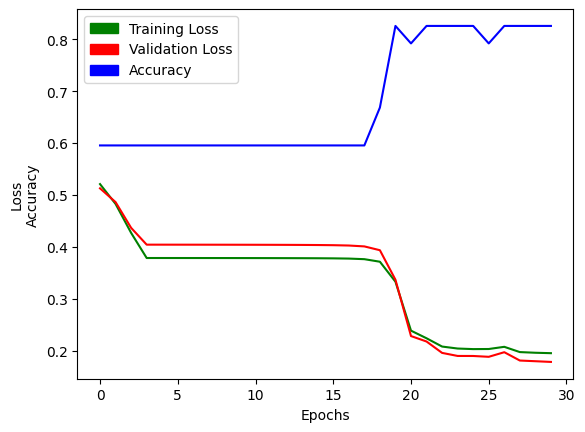

In [196]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

xs = [i for i in range(30)]

plt.plot(xs, res[0], c='green');
plt.plot(xs, res[1], c='red');
plt.plot(xs, res[2], c='blue');

plt.xlabel("Epochs");
plt.ylabel("Loss\nAccuracy");

green_patch = mpatches.Patch(color='green', label='Training Loss')
red_patch = mpatches.Patch(color='red', label='Validation Loss')
blue_patch = mpatches.Patch(color='blue', label='Accuracy')


plt.legend(handles=[green_patch, red_patch, blue_patch]);

Excellent! With that confirmed, I can run my trial of 100 trainings, and then plot the results:

### Training Multiple Models

In [198]:
recorder = train_multiple_models()

In [199]:
recorder.head()

,run,epoch,trn_loss,val_loss,acc
0,0,0,0.552340,0.540915,0.595506
1,0,1,0.488773,0.491162,0.595506
2,0,2,0.474533,0.479952,0.595506
3,0,3,0.461460,0.469660,0.595506
4,0,4,0.450005,0.460642,0.595506


In [200]:
recorder.tail()

,run,epoch,trn_loss,val_loss,acc
25,99,25,0.390775,0.414015,0.595506
26,99,26,0.390258,0.413608,0.595506
27,99,27,0.389781,0.413232,0.595506
28,99,28,0.389341,0.412886,0.595506
29,99,29,0.388933,0.412565,0.595506


In [202]:
recorder.max()

run               99
epoch             29
trn_loss    0.623253
val_loss    0.604715
acc         0.831461
dtype: object

#### Plot: Training Loss

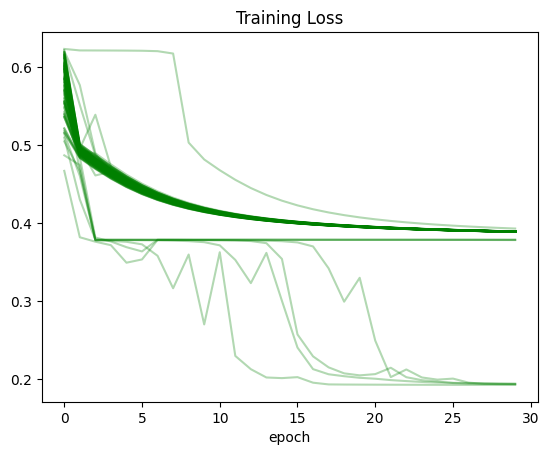

In [205]:
(recorder
 .pivot_table(values='trn_loss', index='epoch', columns='run')
 .plot(color='green', alpha=0.3, legend=False, title='Training Loss'));

#### Plot: Validation Loss

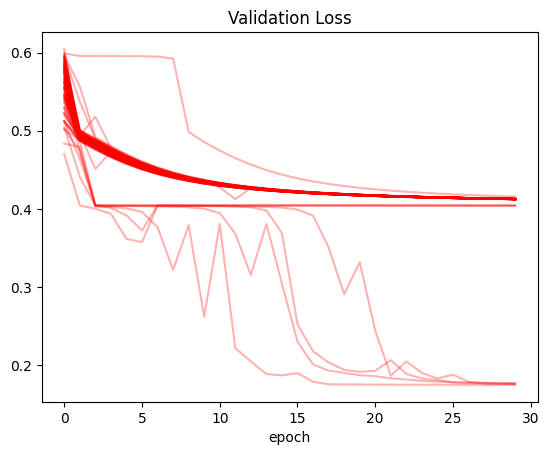

In [206]:
(recorder
 .pivot_table(values='val_loss', index='epoch', columns='run')
 .plot(color='red', alpha=0.3, legend=False, title='Validation Loss'));

#### Plot: Accuracy

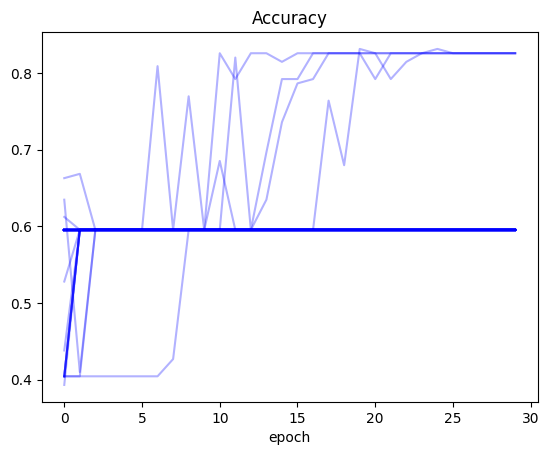

In [207]:
(recorder
 .pivot_table(values='acc', index='epoch', columns='run')
 .plot(color='blue', alpha=0.3, legend=False, title='Accuracy'));

### Final Thoughts

This exercise was fascinating, both in terms of building the code to record losses and accuracy for each epoch, as well as observing the final results of 100 training runs.

The main observation that stands out: for all three values (training loss, validation loss and accuracy) there were training runs where the values did not improve at all between the first and last epoch. In the case of training and validation loss, it seems like there were numerous runs where the loss was stuck at around `0.4`. There were many trainings where the accuracy was stuck at around `0.6`.

Only for a handful of training runs did the accuracy cross `0.8`.

In a significant number of runs (as seen by the darkness of the line color on the plot) the training and validation loss gradually decreased during training.

After running this experiment I am pretty surprised. I knew that training neural networks involved some variability, but it's almost shocking to see how you can get wildly different results for training the same model. Just by happenchance, I can get a model that seemingly does not work (accuracy stuck throughout) and the same model that achieves a better accuracy than the baseline in Jeremy's notebook. All in all, I'm grateful that I did this exercise because it gave me some perspective on how volatile neural nets can be.